In [1]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 8.3 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import scipy
from arch import arch_model
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Function to Get Stock Returns in a Portfolio

In [4]:
def fixWeights(weights):
    weights = np.array(weights)
    return weights / weights.sum()

def getReturns(tickers, start = '2014-01-01', end = '2024-11-22'):
    prices = yf.download(tickers, start = start, end = end, progress = False)['Close'][tickers]
    returns = prices.pct_change().dropna()
    return returns

In [5]:
tickers = ['AAPL', 'GOOG']
weights = [0.5, 0.5]
data = getReturns(tickers)
data

Ticker,AAPL,GOOG
Date,,
2014-01-03,-0.021966,-0.007295
2014-01-06,0.005453,0.011149
2014-01-07,-0.007152,0.019278
2014-01-08,0.006333,0.002081
2014-01-09,-0.012770,-0.009630
...,...,...
2024-11-15,-0.014109,-0.019509
2024-11-18,0.013422,0.016735
2024-11-19,0.001140,0.015724


## Monte Carlo VaR

In [6]:
def MonteCarloVaR(data, weights, sims = 1000, level = 0.05):
    data = (data * fixWeights(weights)).sum(axis = 1)
    sim_data = np.random.choice(data, size = sims, replace = True)
    return np.quantile(sim_data, level)

In [7]:
MonteCarloVaR(data, weights)

-0.02301472392887989

## Parametric VaR

In [8]:
def ParametricVaR(data, weights, level = 0.05):
    weights = fixWeights(weights)
    ret_mean = np.mean(data, axis = 0)
    ret_cov = np.cov(data, rowvar = False)
    port_mean = np.dot(weights, ret_mean)
    port_var = np.dot(weights.T, np.dot(ret_cov, weights))
    port_std = np.sqrt(port_var)
    return scipy.stats.norm.ppf(0.05, loc = port_mean, scale = port_std)

In [9]:
ParametricVaR(data, weights)

-0.02483972682602798

## EWMA VaR

In [10]:
def EWMAVaR(data, weights, lam = 0.94, level = 0.05):
    data = (data*fixWeights(weights)).sum(axis = 1)
    Z = scipy.stats.norm.ppf(level)
    sig2 = [np.var(data)]
    for i in range(1, len(data)):
        sig2.append(lam * sig2[-1] + (1 - lam) * (data[i-1]**2))
    new_sig2 = lam * sig2[-1] + (1-lam) * data[-1]**2
    vol = np.sqrt(new_sig2)
    var = Z * vol
    return var

In [11]:
EWMAVaR(data, weights)

-0.019636120792063942

## GARCH VaR

In [12]:
def GARCHVaR(data, weights, level = 0.05):
    data = (data * fixWeights(weights)).sum(axis = 1)
    Z = scipy.stats.norm.ppf(level)
    model = arch_model(data, vol = 'Garch', p = 1, q = 1, dist = 'normal')
    fit = model.fit(disp = 'off')
    fc = fit.forecast(horizon = 1)
    fc_variance = fc.variance.values[-1, 0]
    fc_vol = np.sqrt(fc_variance)
    var = fc_vol * Z
    return var

In [13]:
GARCHVaR(data, weights)

-0.021840686441093073

## Rolling VaR Backtest

In [14]:
def BacktestVaR(tickers, weights, start = '2014-01-01', end = '2024-11-22', roll_len = 252, sims = 1000, level = 0.05, lam = 0.94):
    data = getReturns(tickers, start, end)
    VaR_MC = []
    VaR_Param = []
    VaR_EWMA = []
    VaR_GARCH = []
    for i in range(len(data)-1):
        if i < roll_len:
            VaR_MC.append(np.nan)
            VaR_Param.append(np.nan)
            VaR_EWMA.append(np.nan)
            VaR_GARCH.append(np.nan)
        else:
            window = data.iloc[(i - roll_len):i]
            VaR_MC.append(MonteCarloVaR(window, weights, sims, level))
            VaR_Param.append(ParametricVaR(window, weights, level))
            VaR_EWMA.append(EWMAVaR(window, weights, lam, level))
            VaR_GARCH.append(GARCHVaR(window, weights, level))
    return VaR_MC, VaR_Param, VaR_EWMA, VaR_GARCH

In [15]:
def getProportion(returns, vars):
    return sum(vars > returns) / len(vars)

In [16]:
def BacktestProportions(tickers, weights, start = '2014-01-01', end = '2024-11-22', roll_len = 252, sims = 1000, level = 0.05, lam = 0.94):
    M, P, E, G = BacktestVaR(tickers, weights, start, end, roll_len, sims, level, lam)
    data = getReturns(tickers, start, end)
    data = (data * fixWeights(weights)).sum(axis = 1)[1:]
    Mp = getProportion(data[roll_len:], M[roll_len:])
    Pp = getProportion(data[roll_len:], P[roll_len:])
    Ep = getProportion(data[roll_len:], E[roll_len:])
    Gp = getProportion(data[roll_len:], G[roll_len:])
    n = len(data)
    return [Mp, Pp, Ep, Gp, n]

In [17]:
props = BacktestProportions(tickers, weights)

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/d

In [18]:
props

[0.05747588424437299,
 0.06109324758842444,
 0.053858520900321546,
 0.05265273311897106,
 2740]

## Binomial Test

In [19]:
def binom_test(props, level = 0.05):
  n = props[4]
  k = np.round(np.array(props[0:4]) * n).astype(int)
  pvals = [scipy.stats.binomtest(val, n, level, alternative = 'two-sided').pvalue for val in k]
  return pvals


In [20]:
binom_test(props)

[0.08713645080447449,
 0.010922037486840827,
 0.3347194476636617,
 0.5392899894624317]

## Kupiec Test


In [21]:
def kupiec_test(props, level = 0.05):
  n = props[4]
  x = np.array(props[0:4]) * n
  pi0 = level
  pi1 = x / n
  LR = -2 * np.log(((1-pi0)**(n-x) * pi0**x) / ((1-pi1)**(n-x) * pi1**x))
  pval = 1 - scipy.stats.chi2.cdf(LR, df = 1)
  return pval

In [22]:
kupiec_test(props)

array([0.07915508, 0.00991453, 0.35978075, 0.52745209])

## GARCH Plot

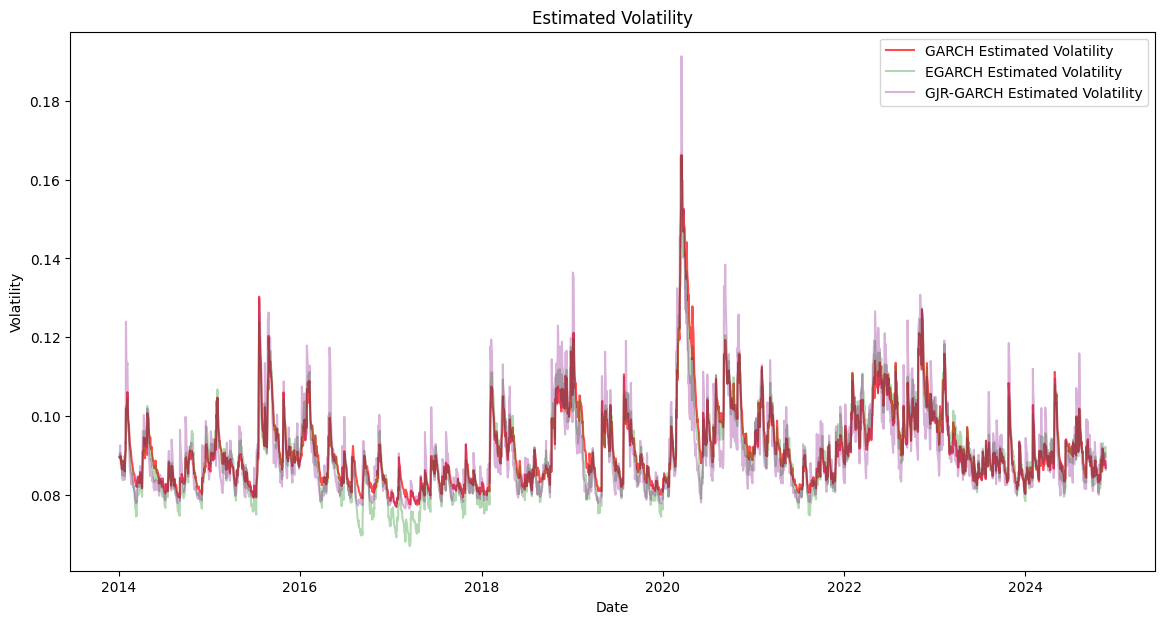

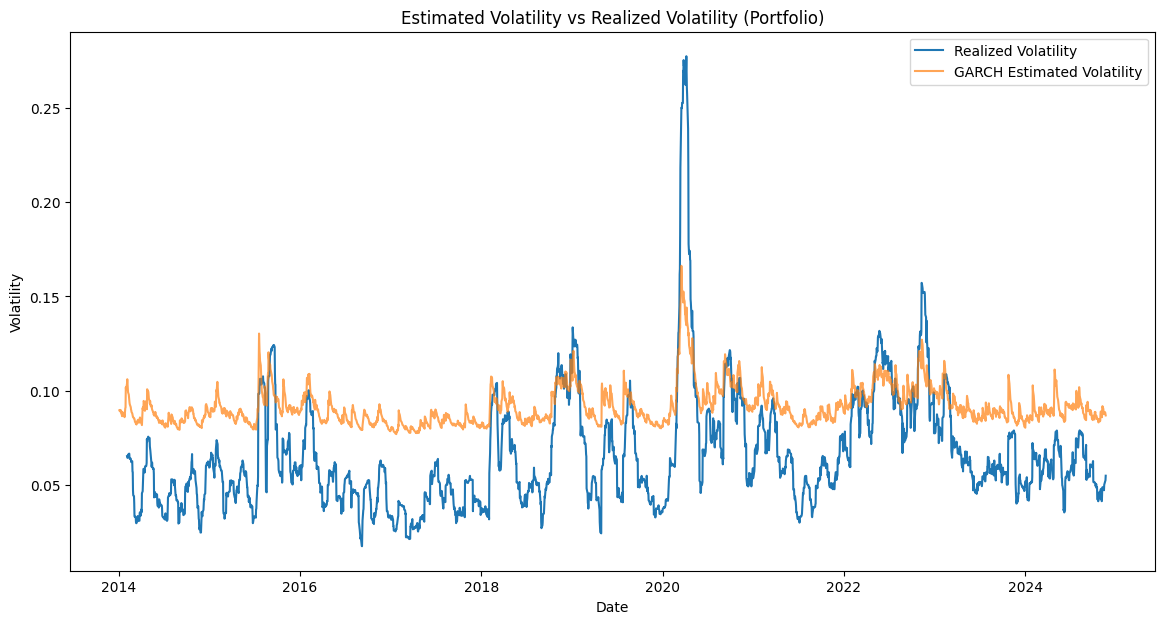

In [ ]:
# Get the portfolio returns for GARCH, EGARCH, and GJR-GARCH volatility calculation
fixed_weights = fixWeights(weights)
weighted_returns = data * fixed_weights
portfolio_returns = weighted_returns.sum(axis=1)

# Fit models for each stock and aggregate the volatilities
garch_volatilities = []
egarch_volatilities = []
gjr_garch_volatilities = []
for ticker in tickers:
    returns = data[ticker]

    # GARCH
    garch_model = arch_model(returns, vol='Garch', p=1, q=1)
    garch_fitted = garch_model.fit(disp='off')
    garch_volatility = np.sqrt(garch_fitted.conditional_volatility)
    garch_volatility = pd.Series(garch_volatility, index=returns.index)  # Align with original dates
    garch_volatilities.append(garch_volatility)

    # EGARCH
    egarch_model = arch_model(returns, vol='EGARCH', p=1, q=1)
    egarch_fitted = egarch_model.fit(disp='off')
    egarch_volatility = np.sqrt(egarch_fitted.conditional_volatility)
    egarch_volatility = pd.Series(egarch_volatility, index=returns.index)  # Align with original dates
    egarch_volatilities.append(egarch_volatility)

    # GJR-GARCH
    gjr_garch_model = arch_model(returns, vol='Garch', p=1, o=1, q=1)
    gjr_garch_fitted = gjr_garch_model.fit(disp='off')
    gjr_garch_volatility = np.sqrt(gjr_garch_fitted.conditional_volatility)
    gjr_garch_volatility = pd.Series(gjr_garch_volatility, index=returns.index)  # Align with original dates
    gjr_garch_volatilities.append(gjr_garch_volatility)

# Aggregate volatilities for the portfolio
garch_volatility_portfolio = np.sqrt(np.sum([w**2 * v**2 for w, v in zip(fixed_weights, garch_volatilities)], axis=0))
egarch_volatility_portfolio = np.sqrt(np.sum([w**2 * v**2 for w, v in zip(fixed_weights, egarch_volatilities)], axis=0))
gjr_garch_volatility_portfolio = np.sqrt(np.sum([w**2 * v**2 for w, v in zip(fixed_weights, gjr_garch_volatilities)], axis=0))

# Combine into a single DataFrame to ensure alignment
volatility_df = pd.DataFrame({
    'GARCH_Volatility': garch_volatility_portfolio,
    'EGARCH_Volatility': egarch_volatility_portfolio,
    'GJR_GARCH_Volatility': gjr_garch_volatility_portfolio,
    'Realized_Volatility': portfolio_returns.rolling(window=21).std() * np.sqrt(21)
})
plt.figure(figsize=(14, 7))
plt.plot(volatility_df['GARCH_Volatility'], label='GARCH Estimated Volatility', alpha=0.7, color="red")
plt.plot(volatility_df['EGARCH_Volatility'], label='EGARCH Estimated Volatility', alpha=0.3, color="green")
plt.plot(volatility_df['GJR_GARCH_Volatility'], label='GJR-GARCH Estimated Volatility', alpha=0.3, color="purple")
plt.title('Estimated Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Plot the estimated volatilities vs realized volatility
plt.figure(figsize=(14, 7))
plt.plot(volatility_df['Realized_Volatility'], label='Realized Volatility')
plt.plot(volatility_df['GARCH_Volatility'], label='GARCH Estimated Volatility', alpha=0.7)
plt.title('Estimated Volatility vs Realized Volatility (Portfolio)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()